[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

Text(0, 0.5, 'acc')

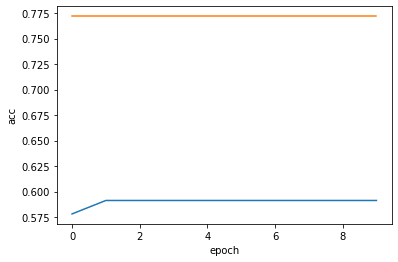

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os

import matplotlib.pyplot as plt

from keras.layers import Layer,Dense,Dropout,Input
from keras import Model,activations
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Layer
from sklearn.datasets import load_breast_cancer

class FM(Layer):
    def __init__(self, output_dim, latent=10,  activation='relu', **kwargs):
        self.latent = latent
        self.output_dim = output_dim
        self.activation = activations.get(activation)
        super(FM, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(name='W0',
                                  shape=(self.output_dim,),
                                  trainable=True,
                                 initializer='zeros')
        self.w = self.add_weight(name='W',
                                 shape=(input_shape[1], self.output_dim),
                                 trainable=True,
                                 initializer='random_uniform')
        self.v= self.add_weight(name='V',
                                 shape=(input_shape[1], self.latent),
                                 trainable=True,
                                initializer='random_uniform')
        super(FM, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        x_square = K.square(x)

        xv = K.square(K.dot(x, self.v))
        xw = K.dot(x, self.w)

        p = 0.5*K.sum(xv-K.dot(x_square, K.square(self.v)), 1)

        rp = K.repeat_elements(K.reshape(p, (-1, 1)), self.output_dim, axis=-1)

        f = xw + rp + self.b

        output = K.reshape(f, (-1, self.output_dim))

        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape)==2
        return input_shape[0],self.output_dim


data = load_breast_cancer()["data"]
target = load_breast_cancer()["target"]

K.clear_session()
print(target)
inputs = Input(shape=(30,))
out = FM(20)(inputs)
out = Dense(15, activation='sigmoid')(out)
out = Dense(1, activation='sigmoid')(out)

model=Model(inputs=inputs, outputs=out)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['acc'])
model.summary()

h=model.fit(data, target, batch_size=1, epochs=10, validation_split=0.2)

#%%

plt.plot(h.history['acc'],label='acc')
plt.plot(h.history['val_acc'],label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
cancer = load_breast_cancer()
#print('breast_cancer数据集的长度为：',len(cancer))
#print('breast_cancer数据集的类型为：',type(cancer))
#print(cancer)
cancer_data = cancer['data']
cancer_target = cancer['target']
cancer_names = cancer['feature_names']
cancer_desc = cancer['DESCR']
#分为训练集与测试集
cancer_data_train,cancer_data_test = train_test_split(cancer_data,test_size=0.2,random_state=42)#训练集
cancer_target_train,cancer_target_test = train_test_split(cancer_target,test_size=0.2,random_state=42)#测试集
#使用sklearn转换器进行数据预处理//离差标准化
Scaler = MinMaxScaler().fit(cancer_data_train)#生成规则
cancer_trainScaler = Scaler.transform(cancer_data_train)
cancer_testScaler = Scaler.transform(cancer_data_test)#此处测试集使用了训练集规则，会有数据结果超过[0,1].
#pca降维
pca_model = PCA(n_components=10).fit(cancer_trainScaler)
cancer_trainPCA = pca_model.transform(cancer_trainScaler)
cancer_testPCA = pca_model.transform(cancer_testScaler)


In [5]:
print(cancer_trainPCA)

[[ 4.76310429e-01  1.20959918e+00  2.76388391e-01 ... -2.24917512e-01
   1.65424732e-01  4.90384948e-01]
 [ 1.59216067e+00  1.88320399e-01 -2.76225968e-01 ...  1.68842391e-01
  -5.54314999e-02 -2.17728173e-01]
 [-4.91209730e-01  4.44643866e-01  4.85148712e-01 ...  8.59736161e-02
   4.83402841e-02  3.82451168e-02]
 ...
 [-6.67778658e-01 -4.81950419e-01 -4.50272062e-03 ...  3.13339929e-02
   6.14829589e-04 -2.14580559e-02]
 [ 2.32454645e-01  1.20410495e-01 -3.91574032e-01 ... -4.14703763e-02
   7.34893327e-02  1.57853853e-03]
 [-5.12962542e-01 -2.02482923e-01 -9.15557107e-02 ...  9.48128918e-02
   4.11997593e-02  5.67193697e-02]]


In [6]:
X = cancer.data
y = cancer.target

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('train score: {train_score:.6f}; test score: {test_score:.6f}'.format(
    train_score=train_score, test_score=test_score))

train score: 0.949451; test score: 0.982456


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
